In [1]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
direc = Path('C:\\projects\\all-projects\\vislearn\\fish\\Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,C:\projects\all-projects\vislearn\fish\Fish_Da...,Red Mullet
1,C:\projects\all-projects\vislearn\fish\Fish_Da...,Striped Red Mullet
2,C:\projects\all-projects\vislearn\fish\Fish_Da...,Hourse Mackerel
3,C:\projects\all-projects\vislearn\fish\Fish_Da...,Sea Bass
4,C:\projects\all-projects\vislearn\fish\Fish_Da...,Sea Bass


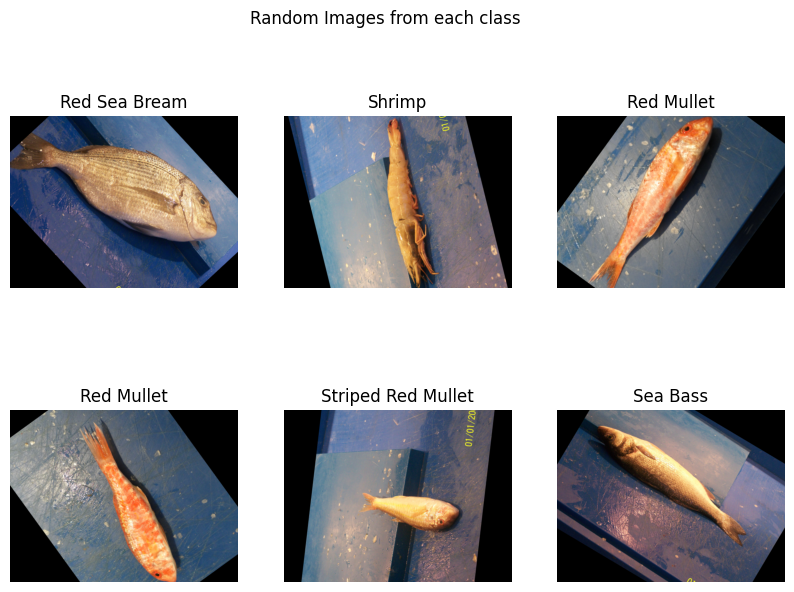

In [3]:
#show 6 random images and their labels
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
fig, ax = plt.subplots(2,3, figsize=(10,7))
fig.suptitle('Random Images from each class')
for i in range(2):
    for j in range(3):
        r = random.randint(0, img_df.shape[0]-1)
        ax[i,j].imshow(mpimg.imread(img_df.loc[r,'FilePaths']))
        ax[i,j].set_title(img_df.loc[r,'Labels'])
        ax[i,j].axis('off')

In [4]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


In [5]:
img_df['Labels'].value_counts(ascending=True)

Red Mullet            1000
Striped Red Mullet    1000
Hourse Mackerel       1000
Sea Bass              1000
Red Sea Bream         1000
Shrimp                1000
Gilt-Head Bream       1000
Black Sea Sprat       1000
Trout                 1000
Name: Labels, dtype: int64

In [6]:
#splitting the data into train and test
train_df, test_df = train_test_split(img_df, train_size=0.7, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f" Count of Rows : {train_df.shape[0]} \n Count of Columns : {train_df.shape[1]} ")
print(f" Count of Rows : {test_df.shape[0]} \n Count of Columns : {test_df.shape[1]} ")


 Count of Rows : 6300 
 Count of Columns : 2 
 Count of Rows : 2700 
 Count of Columns : 2 


In [7]:
#creating the model in pytorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image


c:\projects\all-projects\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
#creating a custom dataset
class FishDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx,'FilePaths']
        image = Image.open(img_path)
        label = self.df.loc[idx,'Labels']
        if self.transform:
            image = self.transform(image)
        return image, label
    
#creating the transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [9]:
#creating the datasets
train_dataset = FishDataset(train_df, train_transform)
test_dataset = FishDataset(test_df, test_transform)


In [10]:
# Create data loaders for training and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

#creating the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [11]:
val_dataset = FishDataset(test_df, test_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [12]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import copy

# Check for the availability of CUDA (GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Creating the model
model = torchvision.models.resnet50(pretrained=True)
model = model.to(device)
model.fc = nn.Linear(2048, 9)

# Creating the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Train the model for multiple epochs
num_epochs = 10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0


c:\projects\all-projects\.conda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\projects\all-projects\.conda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Define the model architecture
from torchvision import models
model = models.resnet18(pretrained=True)


c:\projects\all-projects\.conda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
print(device)

cuda:0


In [28]:
import copy
import torch
import torch.nn as nn

# Function to create class_to_idx mapping from dataset
def create_class_to_idx(dataset):
    classes = set()
    dataset_length = len(dataset)
    print(f"Dataset length: {dataset_length}")  # Debug print
    for idx in range(dataset_length):
        try:
            _, labels = dataset[idx]
            if isinstance(labels, tuple):
                labels = labels[0]  # Adjust according to the actual structure
            if isinstance(labels, str):
                classes.add(labels)
            elif isinstance(labels, list):
                classes.update(labels)
        except Exception as e:
            print(f"Error at index {idx}: {e}")  # Debug print
            continue
    return {class_name: idx for idx, class_name in enumerate(sorted(classes))}

# Assuming train_loader.dataset contains the entire dataset
class_to_idx = create_class_to_idx(train_loader.dataset)

print("Class to Index Mapping:", class_to_idx)

# Train the model for multiple epochs
num_epochs = 10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Check if CUDA is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = train_loader
        else:
            model.eval()   # Set model to evaluate mode
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for batch in dataloader:
            print(f"Batch structure: {batch}")  # Debug print
            inputs, labels = batch  # Unpack the tuple
            print(f"Inputs: {inputs.shape}, Labels: {labels}")  # Debug print

            # Assuming labels is a tuple, unpack it
            if isinstance(labels, tuple):
                labels = labels[0]  # Adjust according to the actual structure

            inputs = inputs.to(device)
            
            # Convert string labels to indices
            if isinstance(labels, str):
                labels = class_to_idx[labels]
                labels = torch.tensor([labels], dtype=torch.long)
            elif isinstance(labels, list):  # Handle batch of labels
                labels = torch.tensor([class_to_idx[label] for label in labels], dtype=torch.long)
            elif isinstance(labels, int):  # If label is already an int
                labels = torch.tensor([labels], dtype=torch.long)

            labels = labels.to(device)

            # Check if input and label batch sizes match
            if inputs.size(0) != labels.size(0):
                print(f"Input batch size: {inputs.size(0)}, Label batch size: {labels.size(0)}")
                continue  # Skip this batch if sizes don't match

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    # Deep copy the model if it has better accuracy
    if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# Load best model weights
model.load_state_dict(best_model_wts)


Dataset length: 6300
Class to Index Mapping: {'Black Sea Sprat': 0, 'Gilt-Head Bream': 1, 'Hourse Mackerel': 2, 'Red Mullet': 3, 'Red Sea Bream': 4, 'Sea Bass': 5, 'Shrimp': 6, 'Striped Red Mullet': 7, 'Trout': 8}
Epoch 0/9
----------
Batch structure: [tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.03

AttributeError: 'int' object has no attribute 'double'